In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.timeseries import LombScargle
import astropy.units as u
import pandas as pd
import matplotlib
params={
    'text.usetex':True,
    'font.family':'serif',
    'xtick.minor.visible':True,
    'ytick.minor.visible':True,
    'xtick.top':True,
    'ytick.left':True,
    'ytick.right':True,
    'xtick.direction':'out',
    'ytick.direction':'out',
    'xtick.minor.size':2.5,
    'xtick.major.size':5,
    'ytick.minor.size':2.5,
    'ytick.major.size':5,
    'axes.axisbelow':True
}
matplotlib.rcParams.update(params)

In [2]:
base = 'AS1G05_230T02_9000000548uvtFIIPC00F1_l2ce'
directory = ['/home/ravioli/astro/ksp/uvit/20160720_G05_230T02_9000000548_level2/uvit/RAS_VIS/uvt_01/F_01/', \
            '/home/ravioli/astro/ksp/uvit/20160720_G05_230T02_9000000548_level2/uvit/RAS_VIS/uvt_02/F_02/', \
            '/home/ravioli/astro/ksp/uvit/20160720_G05_230T02_9000000548_level2/uvit/RAS_VIS/uvt_03/F_03/', \
            '/home/ravioli/astro/ksp/uvit/20160720_G05_230T02_9000000548_level2/uvit/RAS_VIS/uvt_04/F_04/', \
            '/home/ravioli/astro/ksp/uvit/20160720_G05_230T02_9000000548_level2/uvit/RAS_VIS/uvt_05/F_05/', \
            '/home/ravioli/astro/ksp/uvit/20160720_G05_230T02_9000000548_level2/uvit/RAS_VIS/uvt_06/F_06/', \
            '/home/ravioli/astro/ksp/uvit/20160720_G05_230T02_9000000548_level2/uvit/RAS_VIS/uvt_07/F_07/', \
            '/home/ravioli/astro/ksp/uvit/20160720_G05_230T02_9000000548_level2/uvit/RAS_VIS/uvt_08/F_08/', \
            '/home/ravioli/astro/ksp/uvit/20160720_G05_230T02_9000000548_level2/uvit/RAS_VIS/uvt_09/F_09/', \
            '/home/ravioli/astro/ksp/uvit/20160720_G05_230T02_9000000548_level2/uvit/RAS_VIS/uvt_11/F_11/', \
            '/home/ravioli/astro/ksp/uvit/20160720_G05_230T02_9000000548_level2/uvit/RAS_VIS/uvt_13/F_13/', \
            '/home/ravioli/astro/ksp/uvit/20160720_G05_230T02_9000000548_level2/uvit/RAS_VIS/uvt_15/F_15/', \
            '/home/ravioli/astro/ksp/uvit/20160720_G05_230T02_9000000548_level2/uvit/RAS_VIS/uvt_17/F_17/', \
            '/home/ravioli/astro/ksp/uvit/20160720_G05_230T02_9000000548_level2/uvit/RAS_VIS/uvt_19/F_19/', \
            '/home/ravioli/astro/ksp/uvit/20160720_G05_230T02_9000000548_level2/uvit/RAS_VIS/uvt_20/F_20/', \
            '/home/ravioli/astro/ksp/uvit/20160720_G05_230T02_9000000548_level2/uvit/RAS_VIS/uvt_21/F_21/', \
            '/home/ravioli/astro/ksp/uvit/20160720_G05_230T02_9000000548_level2/uvit/RAS_VIS/uvt_22/F_22/', \
            '/home/ravioli/astro/ksp/uvit/20160720_G05_230T02_9000000548_level2/uvit/RAS_VIS/uvt_23/F_23/']

MJD = []
counts = []
counts_err = []
source = pd.DataFrame(pd.read_csv('sources_new.csv'))
for i in range(len(directory)):
    data = pd.read_csv(directory[i]+'makecurves_'+str(source['xp'][i])+'_'+str(source['yp'][i])+'_'+base+'.dat', delimiter='	')
    lc = pd.DataFrame(data)
    MJD.append(lc.iloc[:, 0].values)
    counts.append(lc.iloc[:, 1].values)
    counts_err.append(lc.iloc[:, 2].values)
MJD = np.concatenate(MJD)
counts = np.concatenate(counts)
counts_err = np.concatenate(counts_err)
#np.savetxt('lc.txt', np.c_[MJD, counts, counts_err], delimiter=',', header='MJD, counts, counts_err')
#MJD = 2444884.2176 + MJD*0.07891518

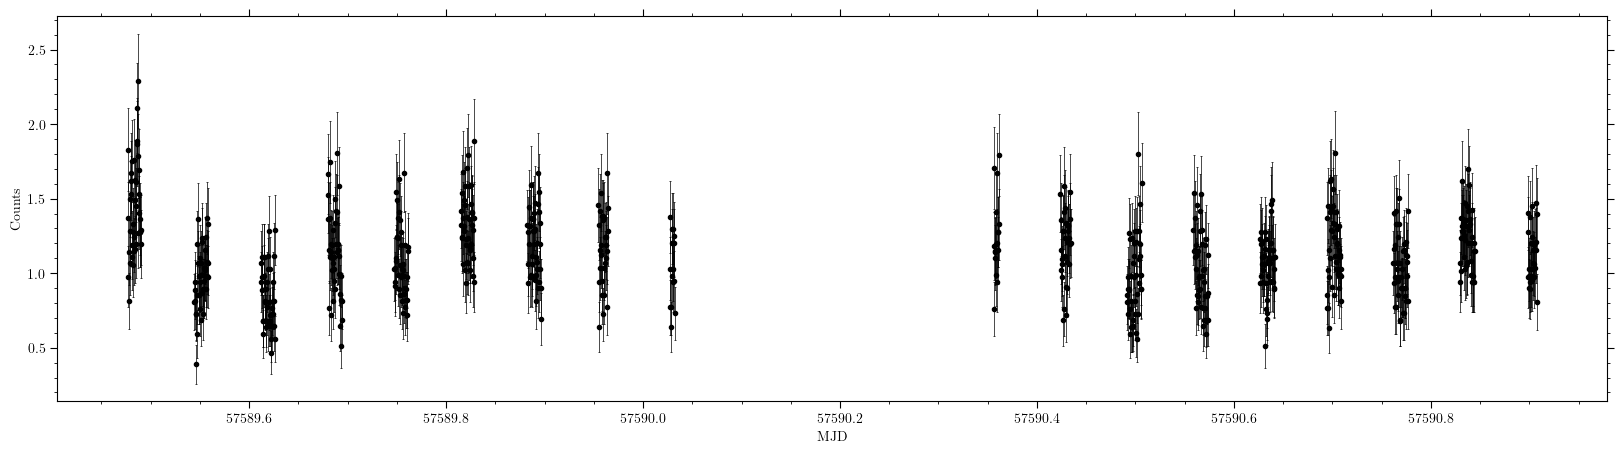

In [3]:
plt.figure(figsize=(20, 5))
plt.errorbar(MJD, counts, yerr=counts_err, fmt='o', color='k', ms=3, elinewidth=0.5, capsize=1, capthick=0.5)
plt.xlabel('MJD')
plt.ylabel('Counts')
plt.show()

(0.0, 10.0)

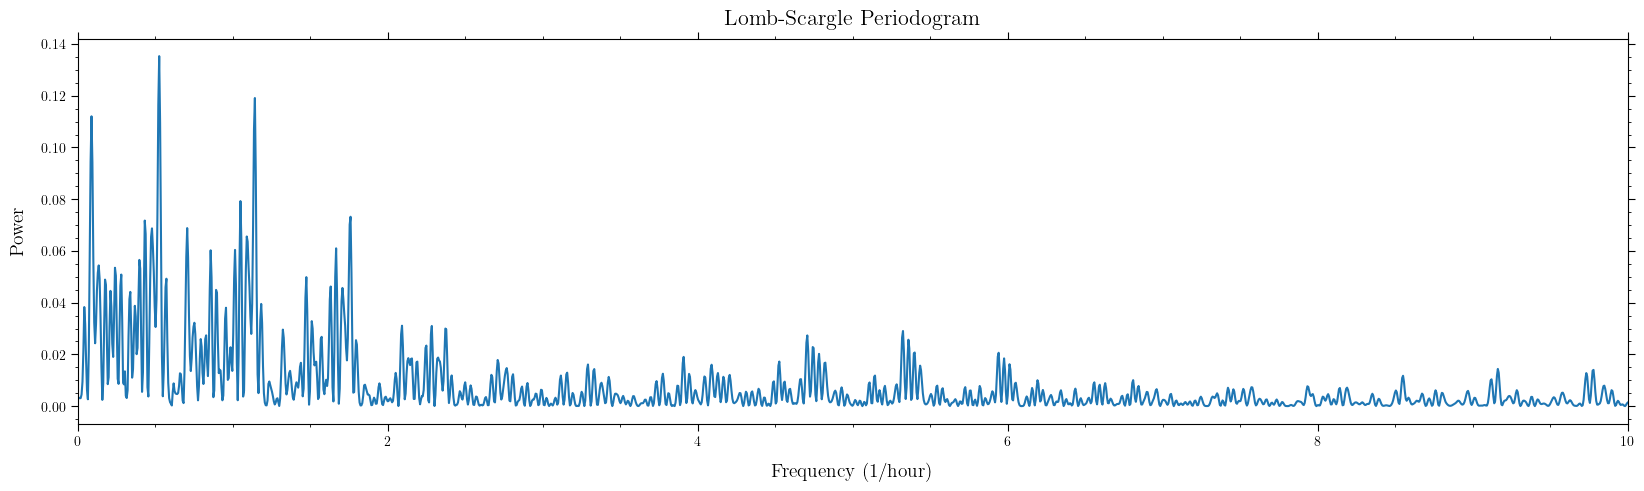

In [4]:
MJD_days = MJD*u.day
#convert to minutes
MJD_hour = MJD*24
frequency, power = LombScargle(MJD_hour, counts).autopower()
plt.figure(figsize=(20, 5))
plt.plot(frequency, power)
plt.xlabel('Frequency (1/hour)', fontsize=14, labelpad=10)
plt.ylabel('Power', fontsize=14, labelpad=10)
plt.title('Lomb-Scargle Periodogram', fontsize=16, pad=10)
plt.xlim(0,10)

<ErrorbarContainer object of 3 artists>

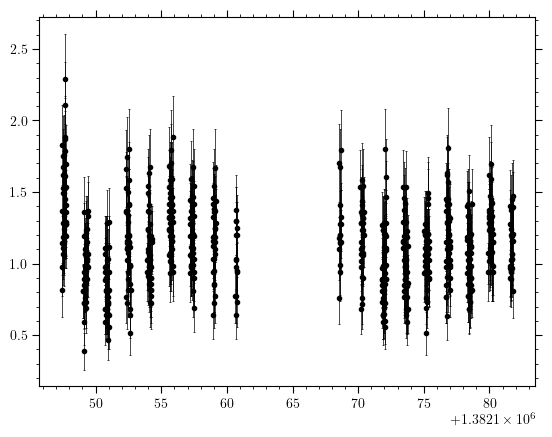

In [5]:
plt.errorbar(MJD_hour, counts, yerr=counts_err, fmt='o', color='k', ms=3, elinewidth=0.5, capsize=1, capthick=0.5)

In [6]:
best_frequency = frequency[np.argmax(power)]
t_fit = np.linspace(0, 1, 100)
ls = LombScargle(MJD, counts, counts_err)
y_fit = ls.model(t_fit, best_frequency)
best_period = 1/best_frequency
print('Best period:', best_period, "hours")

Best period: 1.8974131100569225 hours


Text(0.5, 1.0, 'Phase-folded light curve')

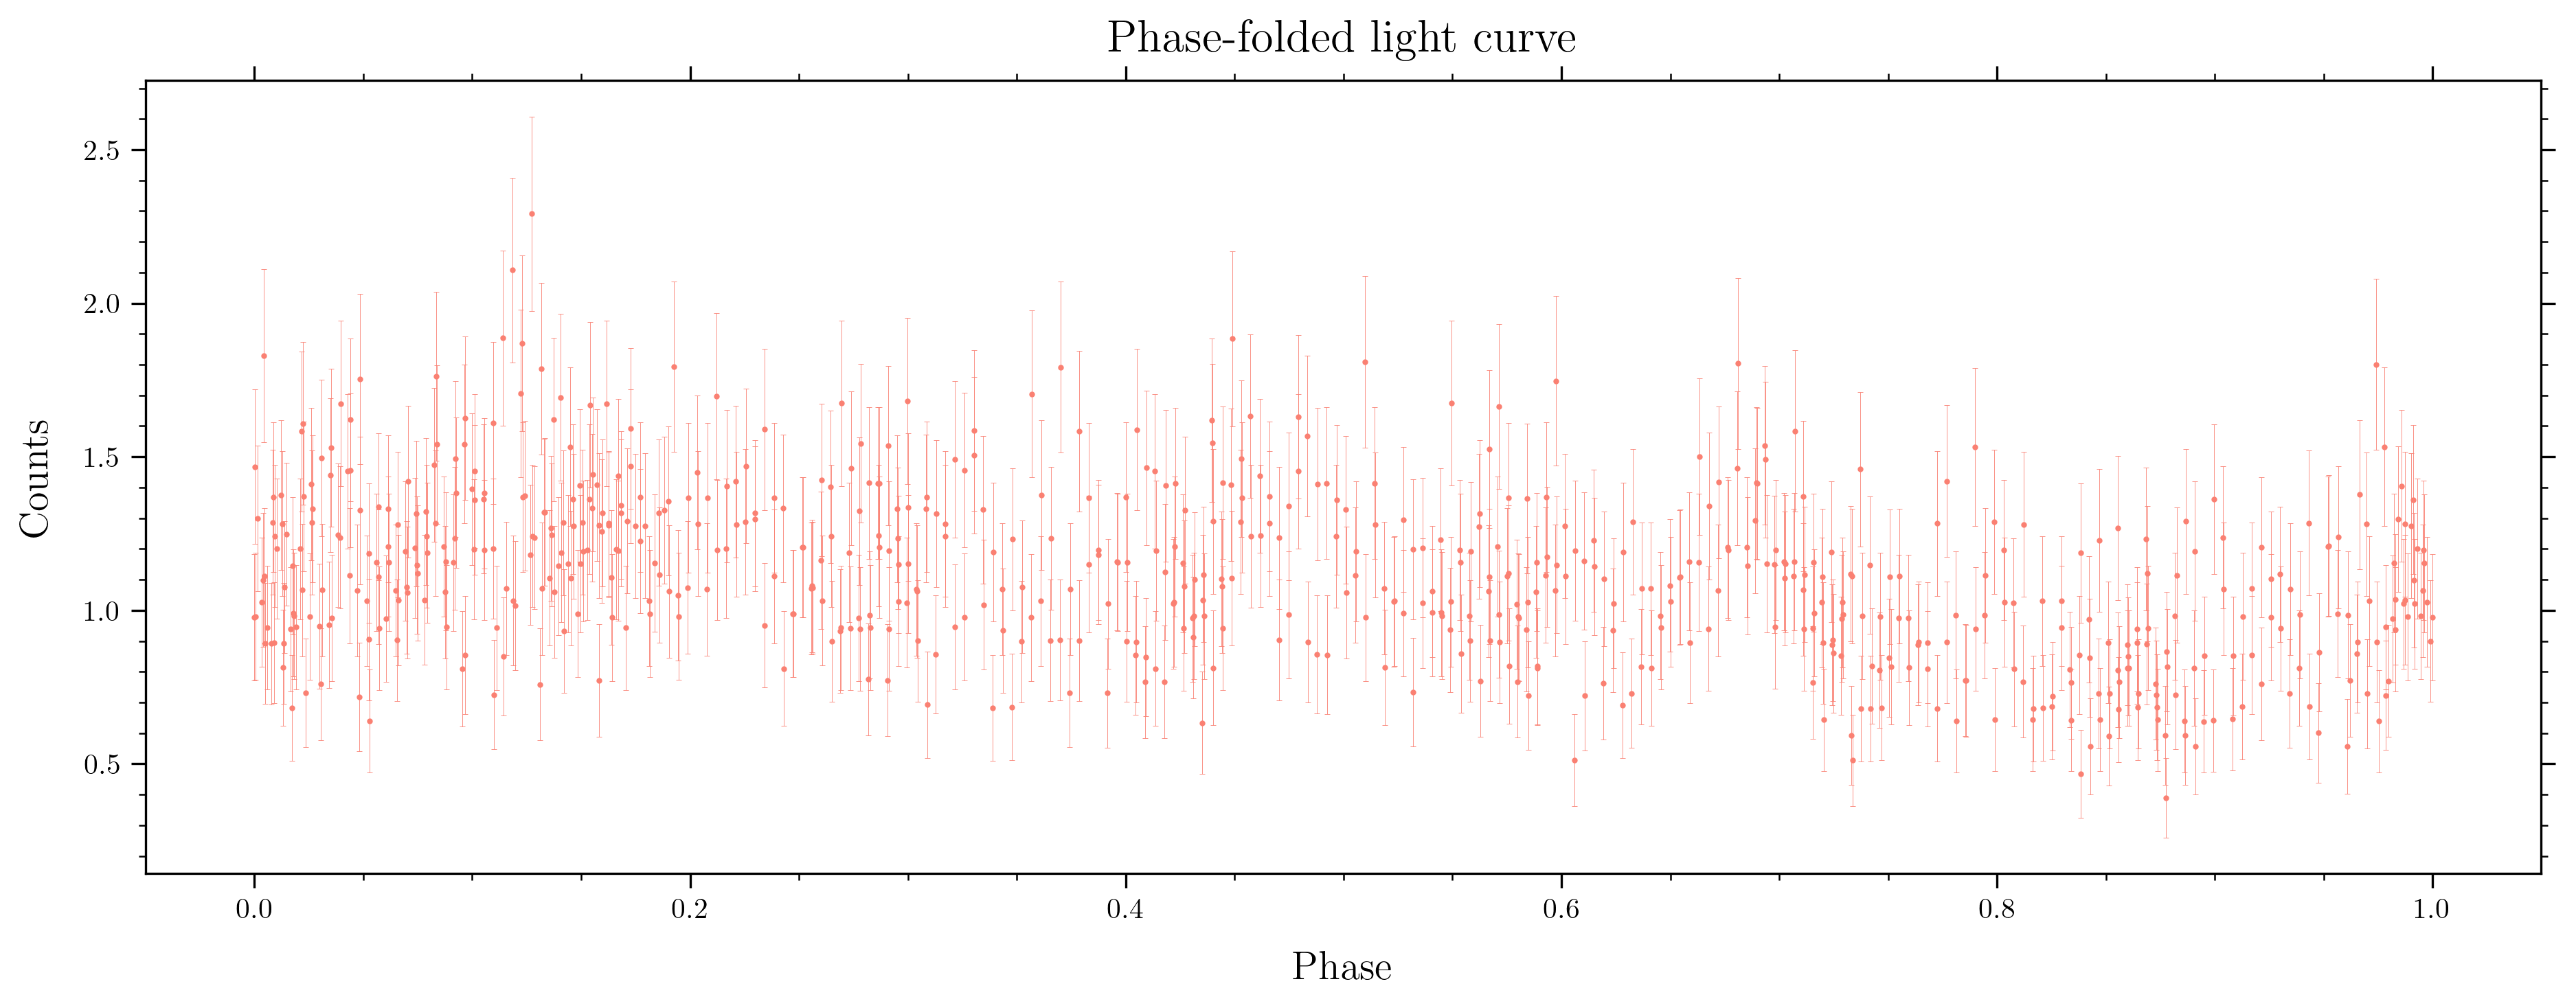

In [35]:
phase = (MJD_hour-min(MJD_hour))/best_period-np.floor((MJD_hour-min(MJD_hour))/best_period)
sort = np.argsort(phase)
plt.figure(figsize=(15, 5), dpi=300)
plt.errorbar(phase[sort], counts[sort], counts_err[sort],fmt='o', color='salmon', ms=1, elinewidth=0.2, capsize=1, capthick=0.2)
plt.xlabel('Phase', fontsize=14, labelpad=10)
plt.ylabel('Counts', fontsize=14, labelpad=10)
plt.title('Phase-folded light curve', fontsize=16, pad=10)